In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
from datetime import timedelta
from utils.acpower import acpower, acpower_resample
import torch

In [2]:
# weather
weather = pd.read_csv("../data/Pecan Street Smart Meter Data (large) (raw)/weather.csv", skiprows=2)
weather["local_time"] = pd.to_datetime(weather[['Year', 'Month', 'Day', 'Hour', 'Minute']])
weather.index = weather["local_time"]
weather.index.name = "utc_time"
weather['date'] = weather['local_time'].dt.date
unique_dates = weather['date'].unique()

In [3]:
weather

,Year,Month,Day,Hour,Minute,DHI,GHI,DNI,Temperature,Wind Speed,local_time,date
utc_time,,,,,,,,,,,,
2018-01-01 00:00:00,2018,1,1,0,0,0,0,0,-2.9,5.3,2018-01-01 00:00:00,2018-01-01
2018-01-01 00:30:00,2018,1,1,0,30,0,0,0,-3.1,5.3,2018-01-01 00:30:00,2018-01-01
2018-01-01 01:00:00,2018,1,1,1,0,0,0,0,-3.2,5.2,2018-01-01 01:00:00,2018-01-01
2018-01-01 01:30:00,2018,1,1,1,30,0,0,0,-3.4,5.2,2018-01-01 01:30:00,2018-01-01
2018-01-01 02:00:00,2018,1,1,2,0,0,0,0,-3.5,5.1,2018-01-01 02:00:00,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 21:30:00,2018,12,31,21,30,0,0,0,-2.0,5.0,2018-12-31 21:30:00,2018-12-31
2018-12-31 22:00:00,2018,12,31,22,0,0,0,0,-2.3,5.1,2018-12-31 22:00:00,2018-12-31
2018-12-31 22:30:00,2018,12,31,22,30,0,0,0,-2.4,5.2,2018-12-31 22:30:00,2018-12-31


/Users/cybsbbbb/Documents/diffusion_load_generation/utils/acpower.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ac = ac.resample('15T').asfreq()
/Users/cybsbbbb/Documents/diffusion_load_generation/utils/acpower.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ac[last_index] = ac[-1]
/Users/cybsbbbb/Documents/diffusion_load_generation/utils/acpower.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ac = ac.resample('15T').asfreq()
/Users/cybsbbbb/Documents/diffusion_load_generation/utils/acpower.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

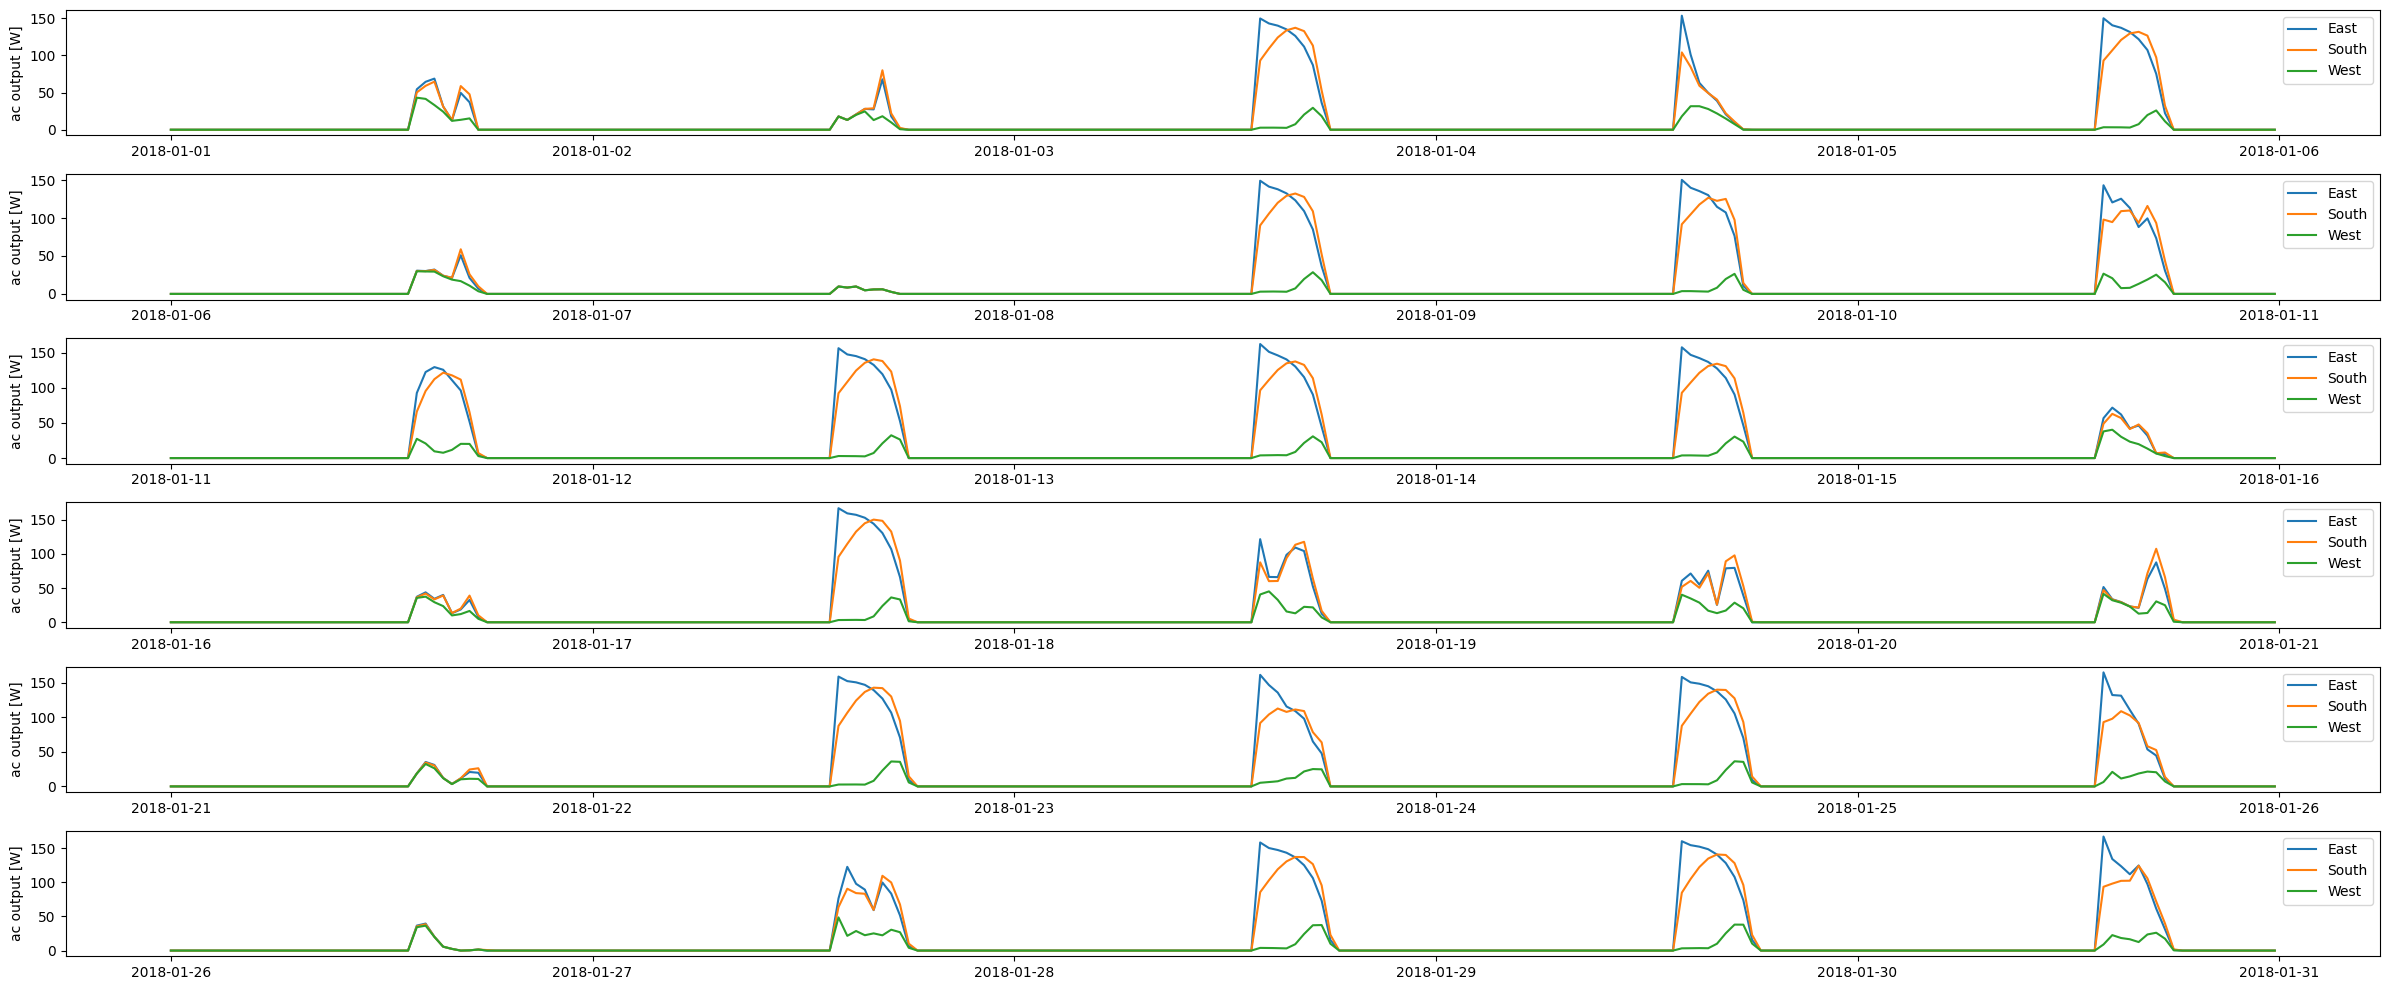

In [4]:
# location
location = (30.2672, -97.7431, 'Pecan Street', 8, 'Etc/GMT+6')
# surface tilt default latitude
surface_tilt = 30.2672
ac_e = acpower_resample(weather, location, surface_tilt, 90)
ac_s = acpower_resample(weather, location, surface_tilt, 180)
ac_w = acpower_resample(weather, location, surface_tilt, 270)

tau = 480 # interval
plt.figure(figsize=(24,10))
for i in range(6):
      plt.subplot(6,1,i+1)
      plt.plot(ac_e[tau*i:tau*(i+1)], label = "East")
      plt.plot(ac_s[tau*i:tau*(i+1)], label = "South")
      plt.plot(ac_w[tau*i:tau*(i+1)], label = "West")
      plt.legend(fontsize=10)
      plt.ylabel("ac output [W]")
plt.tight_layout()

In [5]:
Ac = []
for degree in range(90, 300, 30):
    ac = acpower_resample(weather, location, surface_tilt, 90)
    ac = torch.tensor(ac.values,dtype=torch.float32).T
    # ac = ac.reshape(3, len(unique_dates), -1)
    Ac.append(ac)
Ac = torch.stack(Ac)
Ac = Ac.reshape(Ac.shape[0], -1, 96)
Ac = Ac/1000

/Users/cybsbbbb/Documents/diffusion_load_generation/utils/acpower.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ac = ac.resample('15T').asfreq()
/Users/cybsbbbb/Documents/diffusion_load_generation/utils/acpower.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ac[last_index] = ac[-1]
/var/folders/tz/_b85wmdj0_70tkyzy5p4xq040000gn/T/ipykernel_6674/3730508359.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/T

In [6]:
PV_base = pd.DataFrame({'ac_e': ac_e, 'ac_s': ac_s, 'ac_w': ac_w})
# start_time = pd.Timestamp('2015-10-03 00:00:00')
# end_time = pd.Timestamp('2015-10-30 23:45:00')
# PV_base = PV_base[(PV_base.index >= start_time) & (PV_base.index <= end_time)]
tensor_PV_base = torch.tensor(PV_base.values,dtype=torch.float32).T
tensor_PV_base = tensor_PV_base.reshape(3, len(unique_dates), -1)
tensor_PV_base = tensor_PV_base / 1000
tensor_PV_base.shape

torch.Size([3, 365, 96])

In [7]:
Item = []
for item in [weather["DHI"], weather["DNI"], weather["GHI"], weather["Temperature"], weather["Wind Speed"]]:
    item = item.resample("15T").asfreq()
    item = item.interpolate("linear")
    last_index = item.index[-1] + pd.Timedelta(minutes=15)
    item[last_index] = item[-1]
    item = torch.tensor(item.values,dtype=torch.float32).T
    Item.append(item)
Item = torch.stack(Item)
Item = Item.reshape(5, 365, 96) / 1000


/var/folders/tz/_b85wmdj0_70tkyzy5p4xq040000gn/T/ipykernel_6674/2905123990.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  item = item.resample("15T").asfreq()
/var/folders/tz/_b85wmdj0_70tkyzy5p4xq040000gn/T/ipykernel_6674/2905123990.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item[last_index] = item[-1]
/var/folders/tz/_b85wmdj0_70tkyzy5p4xq040000gn/T/ipykernel_6674/2905123990.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  item = item.resample("15T").asfreq()
/var/folders/tz/_b85wmdj0_70tkyzy5p4xq040000gn/T/ipykernel_6674/2905123990.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

In [8]:
Ac.shape

torch.Size([7, 365, 96])

In [9]:
torch.save(Ac, "../data/Pecan Street Smart Meter Data (large) (tensor)/PV_base_raw.pt")